# Hardcoded Camera Settings

## No fancy logistic curve - only hardcoded settigns to get EV curve

In [1]:
from datetime import timedelta
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
class SettingsWithTime:
    def __init__(self, delta, shutter_speed, iso):
        self.delta = delta
        self.shutter_speed = shutter_speed
        self.iso = iso

        
class SettingsCurve:
    def __init__(self, begins_at, settings_with_time):
        self.begins_at = begins_at
        self.settings_with_time = settings_with_time
        self.df = self.buildSettingsFrame()
    
    def ev(self, iso, shutter_speed, aperture):
        ev100 = math.log2(math.pow(aperture, 2) / shutter_speed)
        if iso > 100:
            return ev100 + math.log2(iso / 100)
        else:
            return ev100

    def buildSettingsArrays(self):
        alpha = self.begins_at
        delta = np.array([], dtype='timedelta64')
        time = np.array([], dtype='datetime64')
        ss = np.array([], dtype=np.dtype('f8'))
        iso = np.array([], dtype=np.dtype('u4'))
        for s in self.settings_with_time:
            alpha += s.delta
            d = alpha
    #         print("Append: " + d.strftime("%Y-%m-%dT%H:%M:%S") + ", " + str(s.shutter_speed) + ", " + str(s.iso))
            time = np.append(time, d)
            delta = np.append(delta, s.delta)
            ss = np.append(ss, s.shutter_speed)
            iso = np.append(iso, s.iso)
        return {'delta': delta, 'time': time, 'shutter_speed': ss, 'iso': iso}
    
    def buildSettingsFrame(self):
        sett = self.buildSettingsArrays()
        d = pd.DataFrame({
            'delta': pd.Series(sett['delta'], dtype='timedelta64[ns]'),
            'time': pd.Series(sett['time'], dtype='datetime64[ns]'),
            'shutter_speed': pd.Series(sett['shutter_speed'], dtype='float64'),
            'iso': pd.Series(sett['iso'], dtype='int32'),
            'aperture': pd.Series(np.full(sett['time'].size, 2.8), dtype='float64')
        })
        d['ev'] = d.apply(lambda r: self.ev(r['iso'], r['shutter_speed'], r['aperture']), axis=1)
        return d
        
    def calcSettingForTime(self, t, column):
        if t < self.df['time'].iloc[0]:
#             print(str(t) + " < " + str(self.df['time'].iloc[0]))
            return self.df[column].iloc[0]
        if t > self.df['time'].iloc[-1]:
#             print(str(t) + " > " + str(self.df['time'].iloc[-1]))
            return self.df[column].iloc[-1]
        diff = self.df['time']-t
        onlyPos = diff[diff <= timedelta(minutes=0)]
        sortss = onlyPos.abs().argsort()
        res = self.df.iloc[sortss[:1]][column]
#         print(res)
        return res.iloc[0]

# 1/8000, 1/4000, 1/2000, 1/1000, 1/500, 1/250, 1/125, 1/60, 1/30, 1/15, 1/8, 1/4, 1/2, 1, 2, 4, 8, 15
settings = np.array([
    SettingsWithTime(timedelta(minutes=20), 15, 1600),
    SettingsWithTime(timedelta(minutes=20), 8, 1600),
    SettingsWithTime(timedelta(minutes=15), 4, 800),
    SettingsWithTime(timedelta(minutes=10), 2, 800),
    SettingsWithTime(timedelta(minutes=5), 1, 800),
    SettingsWithTime(timedelta(minutes=5), 1/2, 400),
    SettingsWithTime(timedelta(minutes=5), 1/4, 400),
    SettingsWithTime(timedelta(minutes=5), 1/8, 400),
    SettingsWithTime(timedelta(minutes=5), 1/15, 400),
    SettingsWithTime(timedelta(minutes=10), 1/30, 400),
    SettingsWithTime(timedelta(minutes=10), 1/60, 400),
    SettingsWithTime(timedelta(minutes=15), 1/125, 400),
    SettingsWithTime(timedelta(minutes=20), 1/250, 400),
    SettingsWithTime(timedelta(minutes=20), 1/500, 400),
    SettingsWithTime(timedelta(minutes=30), 1/1000, 200),
    SettingsWithTime(timedelta(minutes=30), 1/2000, 200),
    SettingsWithTime(timedelta(minutes=40), 1/4000, 100),
    SettingsWithTime(timedelta(minutes=40), 1/8000, 100)
])

# Try out this one later
# https://stackoverflow.com/questions/9463165/data-structure-for-efficiently-retrieving-the-nearest-element-from-a-set

dtFormat = "%Y-%m-%dT%H:%M:%S"
darkness_start_changing_at = datetime.datetime.strptime("2020-07-03T18:00:00", dtFormat)

# Test scenario! it fails - now is before curve starts
# now = datetime.datetime.strptime("2020-07-02T23:49:00", dtFormat)
# now = datetime.datetime.strptime("2020-07-02T19:49:00", dtFormat)

sc = SettingsCurve(darkness_start_changing_at, np.flip(settings))
# display(sc.df)

time_lapse_start = datetime.datetime.strptime("2020-07-03T18:00:00", dtFormat)
resolution =280
data = pd.DataFrame({
    'date_time': pd.DatetimeIndex(pd.to_datetime(time_lapse_start) + pd.to_timedelta(np.arange(resolution), 'm'))
})
data['shutter_speed'] = data.apply(lambda r: sc.calcSettingForTime(r['date_time'], 'shutter_speed'), axis=1)
data['iso'] = data.apply(lambda r: sc.calcSettingForTime(r['date_time'], 'iso'), axis=1)
data['aperture'] = data.apply(lambda r: sc.calcSettingForTime(r['date_time'], 'aperture'), axis=1)
data['ev'] = data.apply(lambda r: sc.ev(r['iso'], r['shutter_speed'], r['aperture']), axis=1)


# display(sc.df)
display(data)

,date_time,shutter_speed,iso,aperture,ev
0,2020-07-03 18:00:00,0.000125,100,2.8,15.936638
1,2020-07-03 18:01:00,0.000125,100,2.8,15.936638
2,2020-07-03 18:02:00,0.000125,100,2.8,15.936638
3,2020-07-03 18:03:00,0.000125,100,2.8,15.936638
4,2020-07-03 18:04:00,0.000125,100,2.8,15.936638
...,...,...,...,...,...
275,2020-07-03 22:35:00,4.000000,800,2.8,3.970854
276,2020-07-03 22:36:00,4.000000,800,2.8,3.970854
277,2020-07-03 22:37:00,4.000000,800,2.8,3.970854
278,2020-07-03 22:38:00,4.000000,800,2.8,3.970854


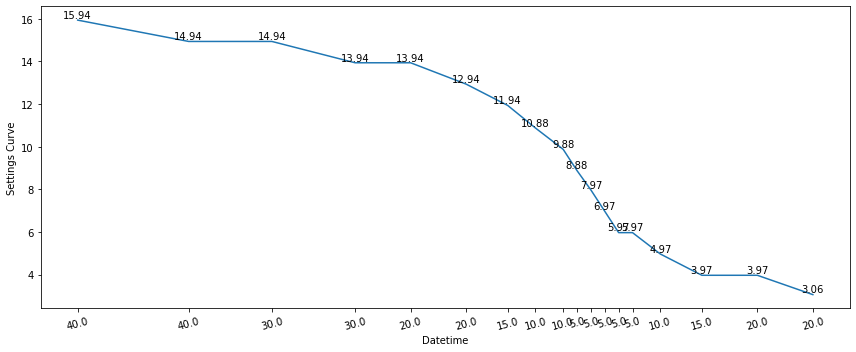

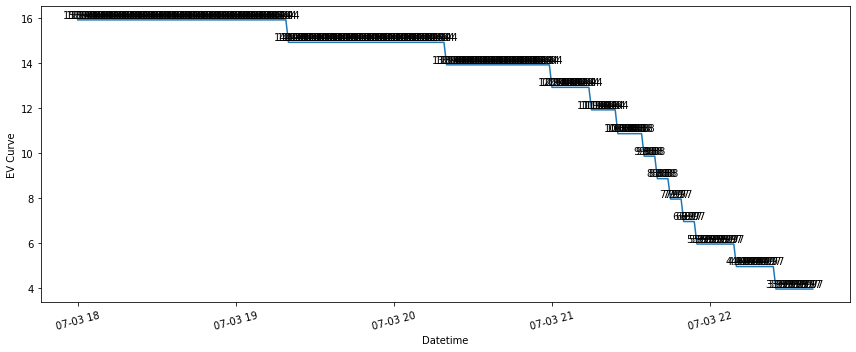

In [60]:
def show_plot(x, y, y_label):
    plt.rcParams["figure.figsize"] = (12,5)
    plt.xticks(rotation=15)
    plt.xlabel("Datetime")
    plt.ylabel(y_label)
    plt.plot(x, y)
    plt.tight_layout()
    for xs,ys in zip(x,y):
        label = "{:.2f}".format(ys)
        plt.annotate(label, # this is the text
                     (xs,ys), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,2), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.show()

def show_plot_special(x, y, x_tick_labels, y_label):
    plt.rcParams["figure.figsize"] = (12,5)
    plt.xticks(ticks=x, labels=x_tick_labels, rotation=15)
    plt.xlabel("Datetime")
    plt.ylabel(y_label)
    plt.plot(x, y)
    plt.tight_layout()
    for xs,ys in zip(x,y):
        label = "{:.2f}".format(ys)
        plt.annotate(label, # this is the text
                     (xs,ys), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,2), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.show()

show_plot_special(sc.df['time'], sc.df['ev'], sc.df['delta'].dt.total_seconds() / (60), "Settings Curve")
show_plot(data['date_time'], data['ev'], "EV Curve")